# Dimension Reduction and Clustering

In [487]:
%pwd
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from matplotlib.patches import Patch
import pandas as pd
import numpy as np
import seaborn as sns
import sklearn as sk
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score
from mpl_toolkits.mplot3d import Axes3D
from scipy import stats
import umap
import umap.plot
import hdbscan
import matplotlib.colors as mcolors
from imblearn.over_sampling import SMOTE

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['font.sans-serif'] = "Helvetica"
matplotlib.rcParams['font.family'] = "sans-serif"

#Random Number
r = 42
labels = [-1, 'CN', 'EMCI', 'LMCI', 'AD']
labels_ad = [-1, 'CONTROL', 'AD']
colors = {'AD':'red', 'CN':'green', 'EMCI':'blue', 'LMCI':'purple'}
colors_binary = {'AD':'red', 'CONTROL':'blue'}

## Load Data

In [491]:
#Loading in data
df = pd.read_csv('Output/expression_matrix.txt', index_col=0).T
dfanno = pd.read_csv('Output/metadata.txt', index_col=0, header=None, squeeze = True)

#Load Genes
genes = pd.read_csv('Output/100_ranked_genes.txt', squeeze=True, header=0)
genes

0      SUMF1 / 11720732_a_at
1      MYEOV / 11755024_a_at
2       SMOX / 11741507_a_at
3      TMCC2 / 11721929_x_at
4        BMF / 11737438_a_at
               ...          
95     SRP14 / 11718663_s_at
96    ZNF271 / 11750558_s_at
97     LMOD2 / 11736713_a_at
98     PVRL3 / 11758970_a_at
99    ZNF471 / 11751506_a_at
Name: 0, Length: 100, dtype: object

In [493]:
#Choose Genes
df = df[genes]
df = df.astype(float)
df

,SUMF1 / 11720732_a_at,MYEOV / 11755024_a_at,SMOX / 11741507_a_at,TMCC2 / 11721929_x_at,BMF / 11737438_a_at,BCL2L11 / 11763147_x_at,AKR1C2 / 11738244_s_at,SLC6A13 / 11759654_a_at,KANSL3 / 11750658_x_at,BPIFA4P / 11750322_at,...,PPARD / 11735395_at,CYP4A11 || CYP4A22 / 11741459_s_at,TRIM10 / 11758611_s_at,TCF7L2 / 11747829_x_at,AGO3 / 11756925_a_at,SRP14 / 11718663_s_at,ZNF271 / 11750558_s_at,LMOD2 / 11736713_a_at,PVRL3 / 11758970_a_at,ZNF471 / 11751506_a_at
116_S_1249,-1.277643,-0.831099,0.807886,-0.941795,-0.573300,-0.448990,1.874984,0.166623,-0.528348,0.453522,...,-2.318080,-0.278232,0.191825,-1.675184,1.761589,0.500874,0.786248,0.395471,0.045678,1.078144
037_S_4410,-1.347309,-1.193127,-2.097621,-0.679543,-2.129096,-0.515147,-0.343558,-0.404871,-1.711251,-0.203923,...,-1.070732,-1.589246,-1.900826,-0.001264,3.326655,0.612513,1.977041,-0.710868,0.264972,-0.886165
006_S_4153,-0.731320,-0.360772,-0.864382,-0.737287,-2.221913,0.571223,-0.507894,0.752405,-0.198381,0.164246,...,0.726917,0.156812,-0.791592,-0.921778,0.505739,1.238660,-0.037046,1.185712,1.603651,-0.701289
116_S_1232,0.698655,0.369473,1.119981,0.930056,0.067581,-1.660709,-0.407466,-0.258426,0.474006,-1.038878,...,-1.176206,1.314973,1.524941,0.259312,0.798680,0.758128,-0.352046,2.050330,-0.144160,0.746907
099_S_4205,-0.243661,-0.654726,-1.440825,-0.643454,-0.714736,0.069822,2.285825,-0.865638,-0.297993,-0.795624,...,-1.139519,-2.171266,-1.761131,0.318792,0.326719,-0.159251,0.013067,0.953288,0.107866,0.600547
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
009_S_2381,-0.390326,-0.651632,0.834670,1.567640,2.273098,3.377678,-1.347836,-0.362009,0.442877,-0.341986,...,-0.465401,1.632438,0.943958,-0.570567,-0.009621,0.563974,-0.242273,-0.562116,-1.256998,-0.169770
053_S_4557,-0.995315,1.152319,0.339744,-0.248873,1.720614,0.188208,-2.215167,0.009462,-1.350154,-0.881091,...,0.172031,-0.372296,1.017968,-1.428769,0.337569,0.850352,0.590566,0.990476,-0.687487,0.007403
073_S_4300,-0.082331,2.009429,1.281851,-0.268121,-0.560041,1.539206,0.240749,-0.512026,-0.291768,-0.177625,...,0.153687,0.832896,1.332514,0.174342,1.748027,0.364966,1.027270,0.878913,-0.550018,-2.018531
041_S_4014,0.566658,-0.382432,-1.105440,-0.330677,2.175861,0.167316,-0.133572,-0.136983,1.389199,1.761838,...,0.227061,0.932839,0.065081,-1.239002,-1.620798,1.374568,-0.449886,-0.729462,-0.913327,-0.239099


In [494]:
#Oversampling
X, y = SMOTE(random_state=r, n_jobs=-1).fit_resample(df, dfanno)

In [495]:
y_ad = np.where(y=='CN', 'CONTROL', y)
y_ad = np.where(y_ad=='LMCI', 'CONTROL', y_ad)
y_ad = np.where(y_ad=='EMCI', 'CONTROL', y_ad)

In [496]:
def fixedWidthClusterMap(df, cmap='RdBu_r', s=30, top=0.05, side=20, num=20, bar=0, up=0, t=0.02, z_score=True):
    # Calulate the figure size
    dpi = plt.rcParams['figure.dpi']
    mw = plt.rcParams['figure.subplot.right']-plt.rcParams['figure.subplot.left']
    mh = plt.rcParams['figure.subplot.top']-plt.rcParams['figure.subplot.bottom']
    Ny,Nx = df.shape
    w = (Nx*s/dpi)/0.8/mw
    h = (Ny*s/dpi)/0.8/mh
    axWidth = (Nx*s)/(w*dpi)
    axHeight = (Ny*s)/(h*dpi)
    
    # do the actual plot
    if z_score:
        grid = sns.clustermap(df, figsize=(w, h), metric="euclidean", center=0, cmap=cmap, cbar_kws={"orientation": "horizontal"}, z_score=0)
    else:
        grid = sns.clustermap(df, figsize=(w, h), metric="euclidean", center=0, cmap=cmap, cbar_kws={"orientation": "horizontal"})


    # resize dendrograms to match
    row = grid.ax_row_dendrogram.get_position()
    grid.ax_row_dendrogram.set_position([row.x0-row.width*(side-1), row.y0, 
                                         row.width*side, axHeight])
    col = grid.ax_col_dendrogram.get_position()
    grid.ax_col_dendrogram.set_position([col.x0, col.y0+col.height*0.01-col.height*up,
                                         axWidth, col.height*top])

    # resize heatmap
    hm = grid.ax_heatmap.get_position()
    grid.ax_heatmap.set_position([hm.x0, hm.y0, 
                                  axWidth, axHeight])

    cbar = grid.cax.get_position()
    grid.cax.set_position([cbar.x0, cbar.y0+col.height*top-col.height*bar-col.height*up, .8, t/(num/20)])

    return grid

In [497]:
def geheatmapclustgene(X, c, title='', top=1, side=1, num=20, bar=0, s=30, up=0, t=0.02):
    #Gene Expression
    ge = pd.DataFrame()
    c = c[c!="NA"]
    for i in c.unique():
        ge[i] = X.T[c[c==i].index].mean(axis=1)

    #Sort
    ge['Standard Deviation'] = ge.std(axis=1) #Standard Deviation
    ge = ge.sort_values(by=['Standard Deviation'], ascending=False)
    ge = ge.drop(['Standard Deviation'], axis=1) 

    #Heatmap
    if num=='all':
        cm = fixedWidthClusterMap(ge.T.corr(), top=top, side=side, s=s, num=ge.T.shape[1], bar=bar, up=up, t=t, z_score=False)
    else:
        cm = fixedWidthClusterMap(ge[:num].T.corr(), top=top, side=side, s=s, num=num, bar=bar, up=up, t=t, z_score=False)

In [498]:
def geheatmapclustgeneall(X, title='', top=1, side=1, num=20, bar=0, s=20, up=0, t=0.02):   
    #Sort
    X=X.T
    X['Standard Deviation'] = X.std(axis=1) #Standard Deviation
    X = X.sort_values(by=['Standard Deviation'], ascending=False)
    X = X.drop(['Standard Deviation'], axis=1) 

    #Heatmap
    if num=='all':
        cm = fixedWidthClusterMap(X.T.corr(), top=top, side=side, s=s, num=X.T.shape[1], bar=bar, up=up, t=t, z_score=False)
    else:
        cm = fixedWidthClusterMap(X[:num].T.corr(), top=top, side=side, s=s, num=num, bar=bar, up=up, t=t, z_score=False)

In [499]:
#Heatmap Gene Expression
def geheatmapclust(X, c, title='', top=0.05, side=20, num=20, s=30, bar=0, up=0, t=0.02):
    #Gene Expression
    ge = pd.DataFrame()
    c = c[c!="NA"]
    for i in c.unique():
        ge[i] = X.T[c[c==i].index].mean(axis=1)

    #Sort
    ge['Standard Deviation'] = ge.std(axis=1) #Standard Deviation
    ge = ge.sort_values(by=['Standard Deviation'], ascending=False)
    ge = ge.drop(['Standard Deviation'], axis=1) 
    
    #Heatmap
    if num=='all':
        cm = fixedWidthClusterMap(ge, top=top, side=side, num=ge.shape[1], bar=bar, s=s, up=up, t=t)
    else:
        cm = fixedWidthClusterMap(ge[:num], top=top, side=side, num=num, bar=bar, s=s, up=up, t=t)

## Correlation Heatmap

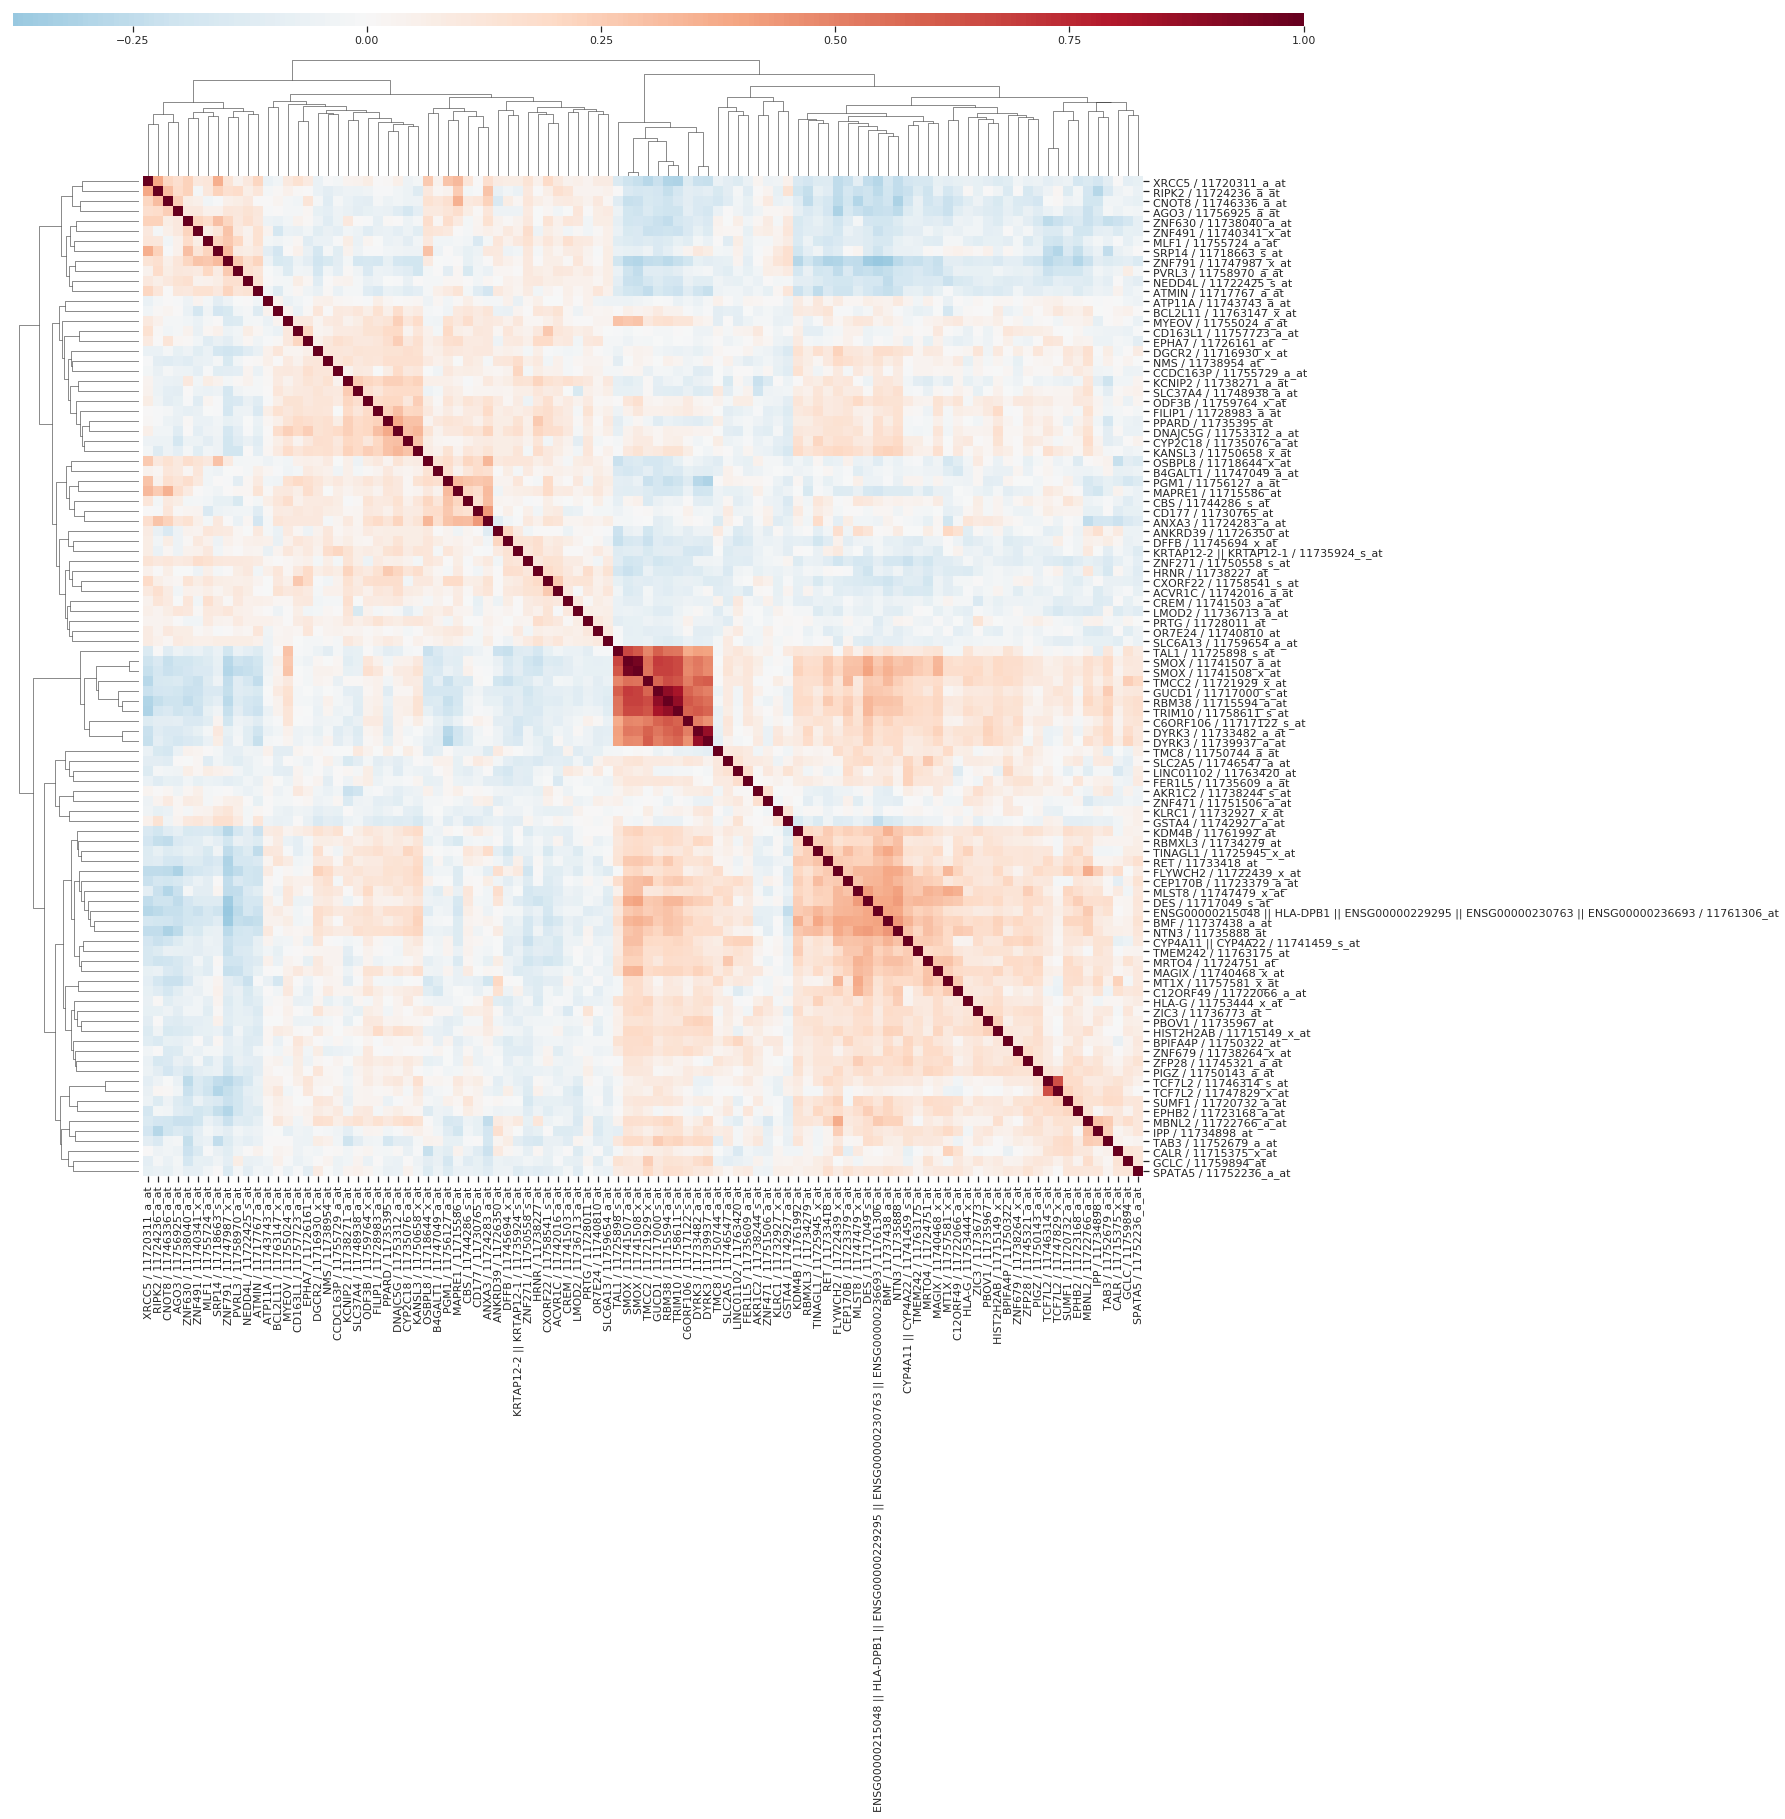

In [500]:
geheatmapclustgeneall(X, title='Pearson Correlation', top=1, side=1, num='all', s=10, up=1, t=0.04)

## PCA

In [501]:
#PCA
pca = PCA()
dfpc = pca.fit_transform(X)

[0.115969   0.05492517 0.04035728 0.03205206 0.02991765 0.02433063
 0.02182362 0.02119276 0.02054206 0.01643372 0.01543609 0.01473909
 0.01432764 0.01348506 0.01331193 0.01290578 0.01279544 0.01219871
 0.01195654 0.01169115 0.01151227 0.01123676 0.01086111 0.01054781
 0.01033492 0.01017742 0.00996173 0.00992603 0.00981762 0.00971982
 0.00945634 0.00933401 0.00922774 0.0090952  0.00902383 0.00887169
 0.00878826 0.00855471 0.00836655 0.00825066 0.00816633 0.0080001
 0.00797329 0.0079271  0.00773213 0.00770959 0.00747651 0.00736235
 0.00725083 0.00720433 0.00697695 0.00690749 0.00679696 0.00671124
 0.00656426 0.00647578 0.0063933  0.00622743 0.00601613 0.00598807
 0.00591124 0.00572597 0.00562022 0.00560415 0.00550038 0.00538468
 0.00526882 0.00525481 0.00519504 0.00501412 0.00495731 0.00478124
 0.00469535 0.00465276 0.00457563 0.00451533 0.00443351 0.0043065
 0.00418781 0.00416059 0.00408079 0.00395694 0.00389748 0.00382726
 0.00374224 0.00366019 0.00347473 0.00334902 0.00315243 0.003087

C:\Users\andre\AppData\Roaming\Python\Python37\site-packages\matplotlib\font_manager.py:1241: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


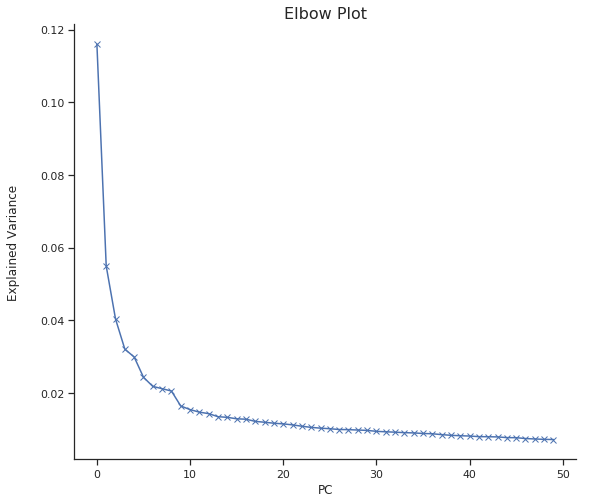

In [502]:
#Scree Plot
print(pca.explained_variance_ratio_)
plt.figure(figsize = (9,8))
plt.plot(pca.explained_variance_ratio_[:50], 'bx-') 
plt.xlabel('PC') 
plt.ylabel('Explained Variance', labelpad=20) 
plt.title('Elbow Plot', fontsize=16)
sns.despine()
plt.savefig('Graphs/Clustering/ElbowPlot.pdf', format='pdf', transparent=True)
plt.show()

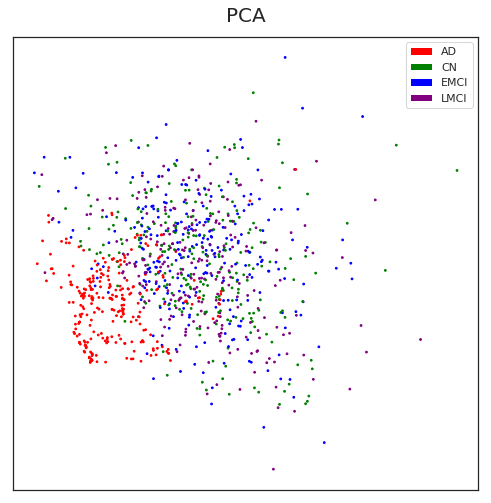

In [503]:
ax = umap.plot._matplotlib_points(dfpc[:,:2], labels=y, color_key=colors, width=600, height=600)
ax.set(xticks=[], yticks=[])
ax.set_title('PCA', fontsize = 20, y=1.02)

plt.savefig('Graphs/Clustering/PCA.pdf', format='pdf', transparent=True)

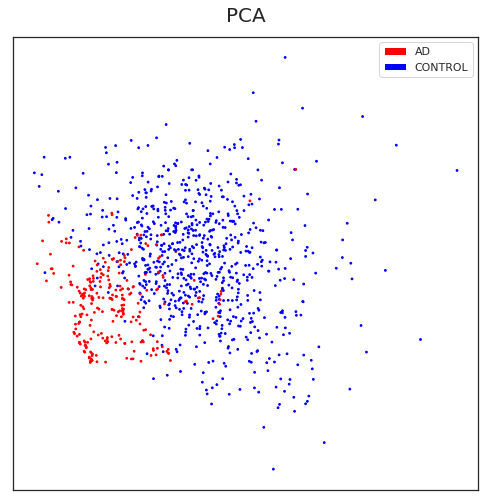

In [504]:
ax = umap.plot._matplotlib_points(dfpc[:,:2], labels=y_ad, color_key=colors_binary, width=600, height=600)
ax.set(xticks=[], yticks=[])
ax.set_title('PCA', fontsize = 20, y=1.02)

plt.savefig('Graphs/Clustering/PCA2.pdf', format='pdf', transparent=True)

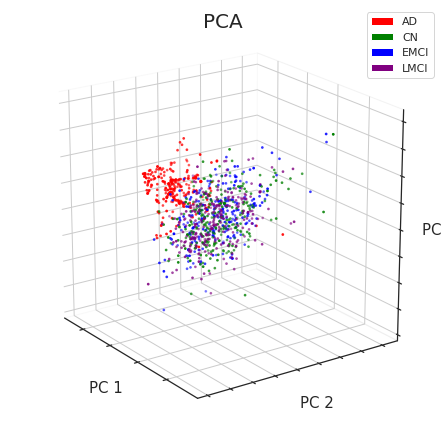

In [505]:
fig = plt.figure(figsize = (6, 6))
ax = fig.add_subplot(1,1,1)
    
principalDf = pd.DataFrame(data = dfpc[:,:3], columns = ['PC 1', 'PC 2', 'PC 3'])
finalDf = pd.concat((principalDf, pd.Series(y)), axis=1)


ax = Axes3D(fig)
ax.set_title('PCA', fontsize = 20, y=1.02)
ax.set_xlabel('PC 1', fontsize = 15)
ax.set_ylabel('PC 2', fontsize = 15)
ax.set_zlabel('PC 3', fontsize = 15)
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False
ax.xaxis.set_ticklabels([])
ax.yaxis.set_ticklabels([])
ax.zaxis.set_ticklabels([])
ax.view_init(20, -35)

finalDf.columns = ['PC 1', 'PC 2', 'PC 3', 'majorCluster']

for label, color in colors.items():
    indicesToKeep = finalDf['majorCluster'] == label
    ax.scatter(finalDf.loc[indicesToKeep, 'PC 1'],
               finalDf.loc[indicesToKeep, 'PC 2'],
               finalDf.loc[indicesToKeep, 'PC 3'],
               c = color, label = label, s = 100.0 / np.sqrt(dfpc[:,:3].shape[0]), marker='o')    
ax.legend(handles=[Patch(facecolor=colors[k], label=k) for k in colors.keys()])

plt.savefig('Graphs/Clustering/PCA3d.pdf', format='pdf', transparent=True)

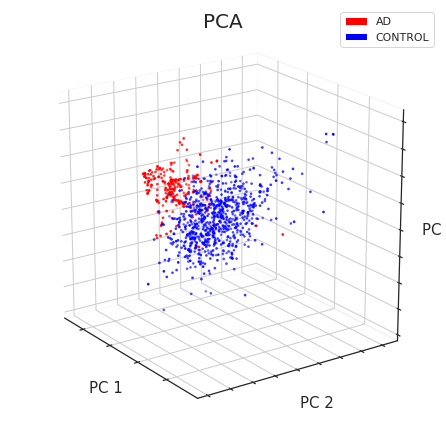

In [506]:
fig = plt.figure(figsize = (6, 6))
ax = fig.add_subplot(1,1,1)
    
principalDf = pd.DataFrame(data = dfpc[:,:3], columns = ['PC 1', 'PC 2', 'PC 3'])
finalDf = pd.concat((principalDf, pd.Series(y_ad)), axis=1)


ax = Axes3D(fig)
ax.set_title('PCA', fontsize = 20, y=1.02)
ax.set_xlabel('PC 1', fontsize = 15)
ax.set_ylabel('PC 2', fontsize = 15)
ax.set_zlabel('PC 3', fontsize = 15)
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False
ax.xaxis.set_ticklabels([])
ax.yaxis.set_ticklabels([])
ax.zaxis.set_ticklabels([])
ax.view_init(20, -35)

finalDf.columns = ['PC 1', 'PC 2', 'PC 3', 'majorCluster']

for label, color in colors_binary.items():
    indicesToKeep = finalDf['majorCluster'] == label
    ax.scatter(finalDf.loc[indicesToKeep, 'PC 1'],
               finalDf.loc[indicesToKeep, 'PC 2'],
               finalDf.loc[indicesToKeep, 'PC 3'],
               c = color, label = label, s = 100.0 / np.sqrt(dfpc[:,:3].shape[0]), marker='o')    
ax.legend(handles=[Patch(facecolor=colors_binary[k], label=k) for k in colors_binary.keys()])

plt.savefig('Graphs/Clustering/PCA3d2.pdf', format='pdf', transparent=True)

In [507]:
pd.crosstab(y, hdb, margins=True)

1,AD,CN,EMCI,LMCI,All
col_0,,,,,
AD 1,38,0,0,0,NaN
AD 2,70,2,2,1,NaN
AD 3,82,1,0,0,NaN
CONTROL,51,256,258,259,NaN
NA,19,1,0,0,NaN
All,0,0,0,0,1040.0


## UMAP

In [508]:
# UMAP
mapper = umap.UMAP(n_neighbors=30, min_dist=0.01, random_state=42).fit(dfpc[:,:20])
clusterable_embedding = umap.UMAP(n_neighbors=30, min_dist=0.01, n_components=2, random_state=42).fit_transform(dfpc[:,:20])

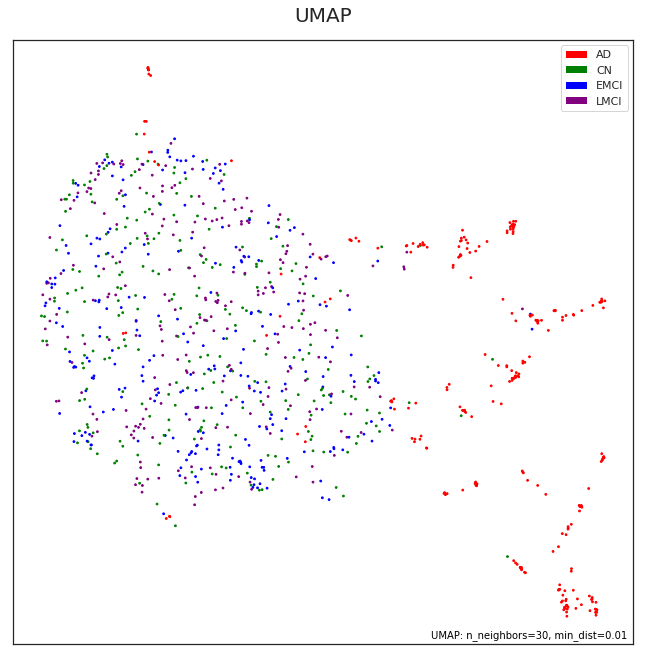

In [509]:
ax = umap.plot.points(mapper, labels=y, color_key=colors)
ax.set_title('UMAP', fontsize = 20, y=1.02)
plt.savefig('Graphs/Clustering/umap.pdf', format='pdf', transparent=True)

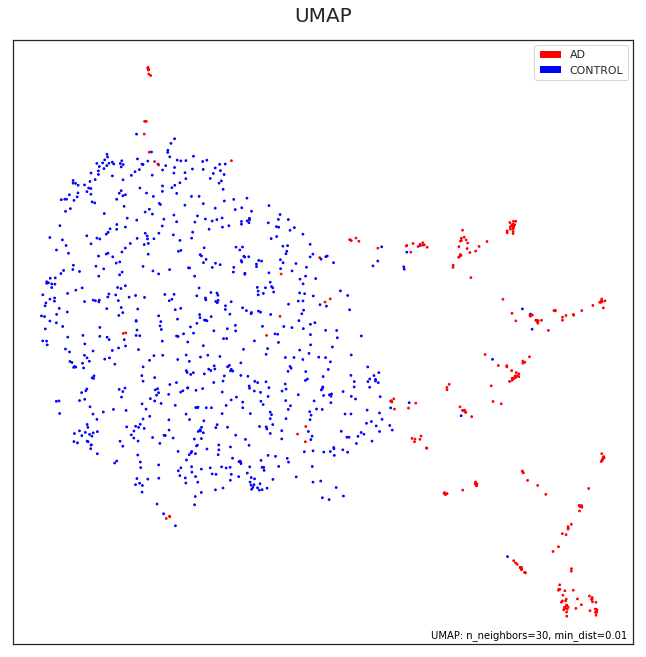

In [510]:
ax = umap.plot.points(mapper, labels=y_ad, color_key=colors_binary)
ax.set_title('UMAP', fontsize = 20, y=1.02)
plt.savefig('Graphs/Clustering/umap2.pdf', format='pdf', transparent=True)

C:\Users\andre\AppData\Roaming\Python\Python37\site-packages\matplotlib\colors.py:512: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
C:\Users\andre\AppData\Roaming\Python\Python37\site-packages\matplotlib\colors.py:512: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


Text(0.5, 1.02, 'UMAP Connectivity')

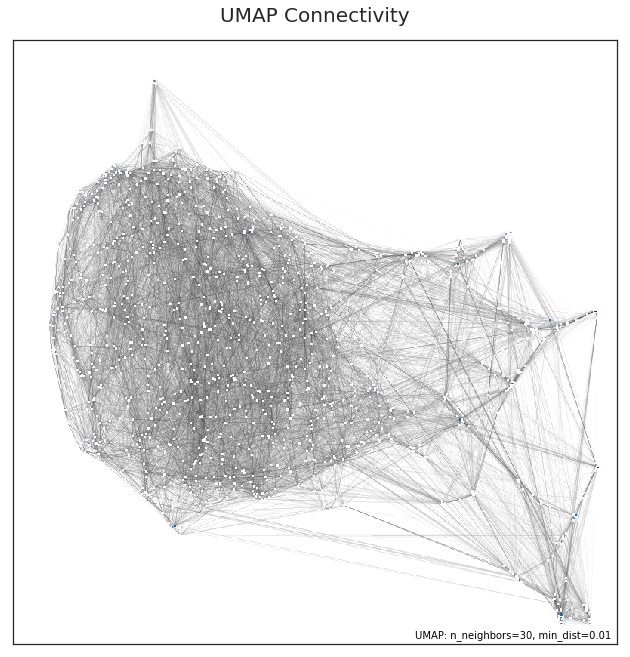

In [511]:
ax = umap.plot.connectivity(mapper, show_points=True)
ax.set_title('UMAP Connectivity', fontsize = 20, y=1.02)


C:\Users\andre\AppData\Roaming\Python\Python37\site-packages\matplotlib\colors.py:512: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


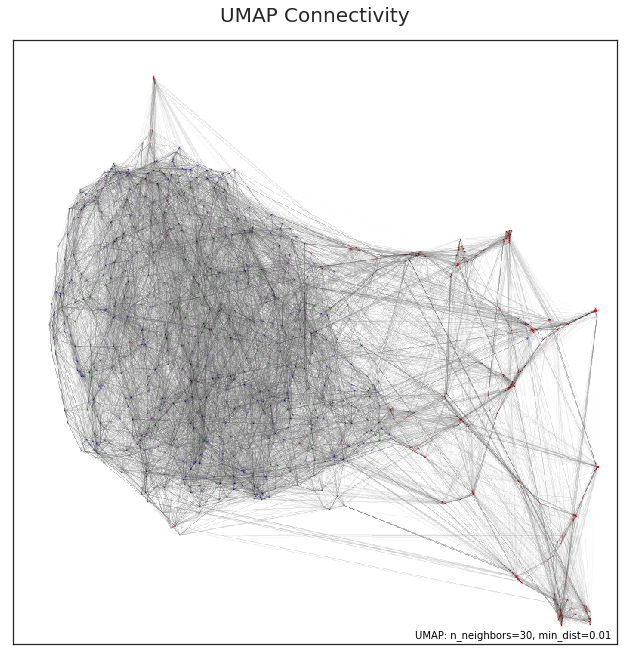

In [512]:
ax = umap.plot.connectivity(mapper, show_points=True, labels=y, color_key=colors)
ax.set_title('UMAP Connectivity', fontsize = 20, y=1.02)
plt.savefig('Graphs/Clustering/umap_connectivity.pdf', format='pdf', transparent=True)

C:\Users\andre\AppData\Roaming\Python\Python37\site-packages\matplotlib\colors.py:512: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


Text(0.5, 1.02, 'UMAP Connectivity')

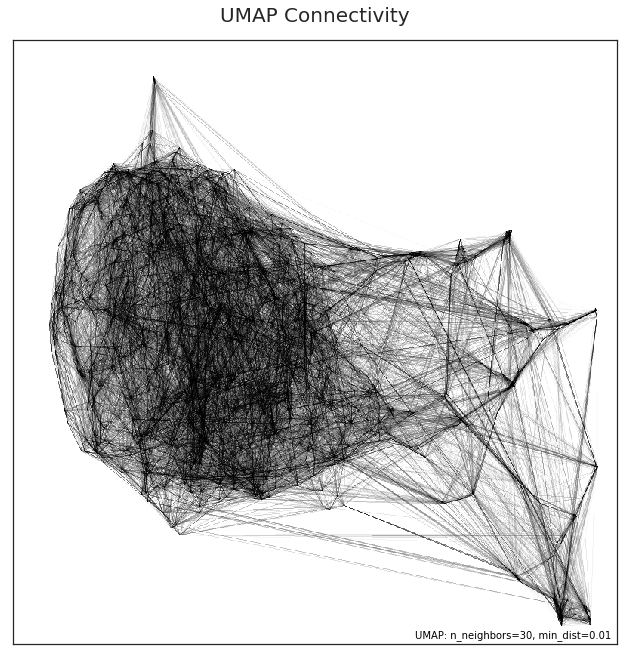

In [513]:
ax = umap.plot.connectivity(mapper)
ax.set_title('UMAP Connectivity', fontsize = 20, y=1.02)


C:\Users\andre\AppData\Roaming\Python\Python37\site-packages\umap\plot.py:854: UserWarning: Hammer edge bundling is expensive for large graphs!
This may take a long time to compute!
  "Hammer edge bundling is expensive for large graphs!\n"
C:\Users\andre\AppData\Roaming\Python\Python37\site-packages\matplotlib\colors.py:512: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


Text(0.5, 1.02, 'Edge Bundled Connectivity')

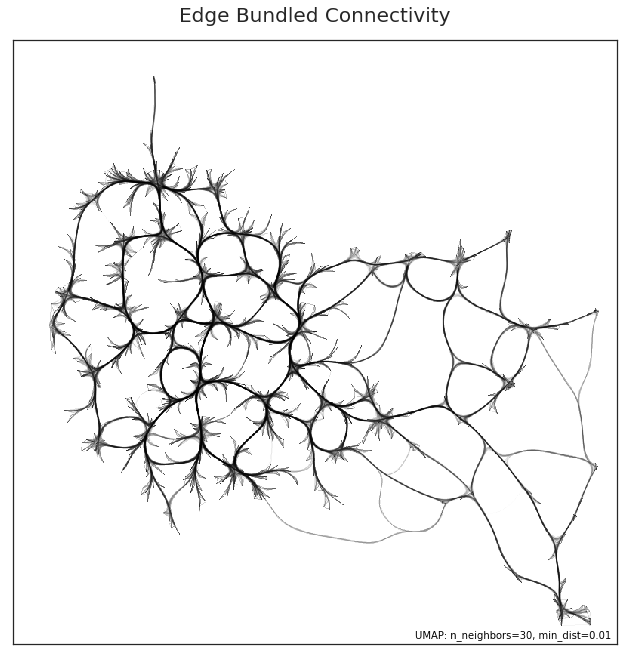

In [514]:
ax = umap.plot.connectivity(mapper, edge_bundling='hammer')
ax.set_title('Edge Bundled Connectivity', fontsize = 20, y=1.02)


C:\Users\andre\AppData\Roaming\Python\Python37\site-packages\umap\plot.py:854: UserWarning: Hammer edge bundling is expensive for large graphs!
This may take a long time to compute!
  "Hammer edge bundling is expensive for large graphs!\n"
C:\Users\andre\AppData\Roaming\Python\Python37\site-packages\matplotlib\colors.py:512: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


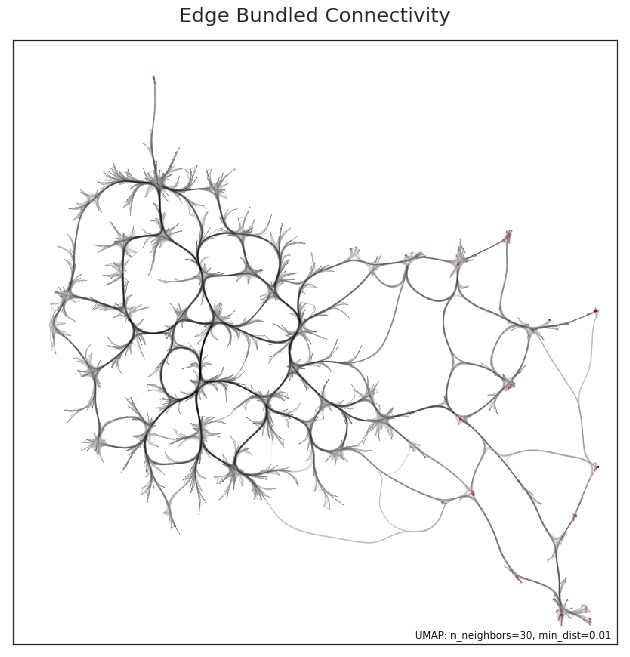

In [515]:
ax = umap.plot.connectivity(mapper, edge_bundling='hammer', show_points=True, labels=y)
ax.set_title('Edge Bundled Connectivity', fontsize = 20, y=1.02)
plt.savefig('Graphs/Clustering/umap_edgebundled_connectivity.pdf', format='pdf', transparent=True)

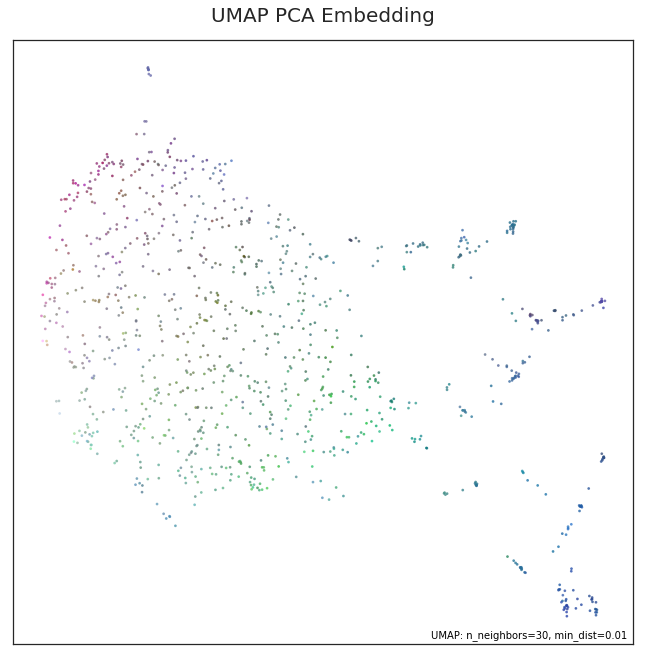

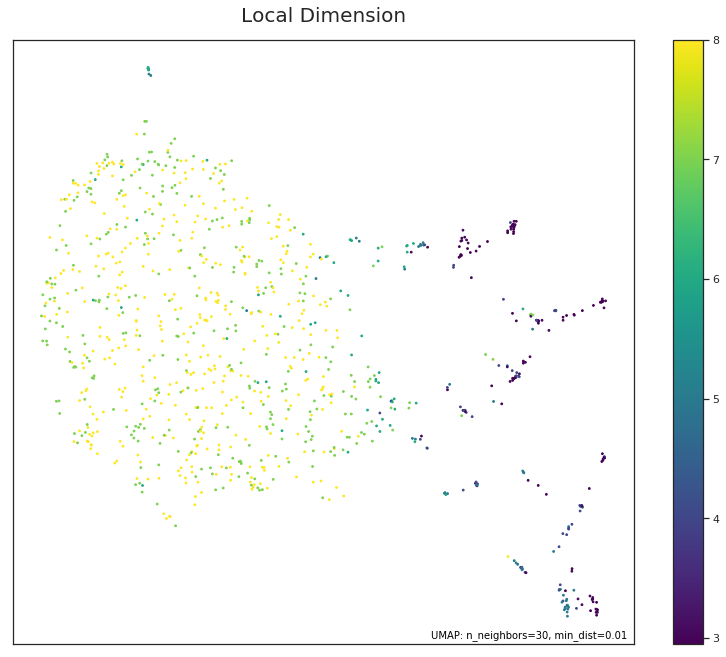

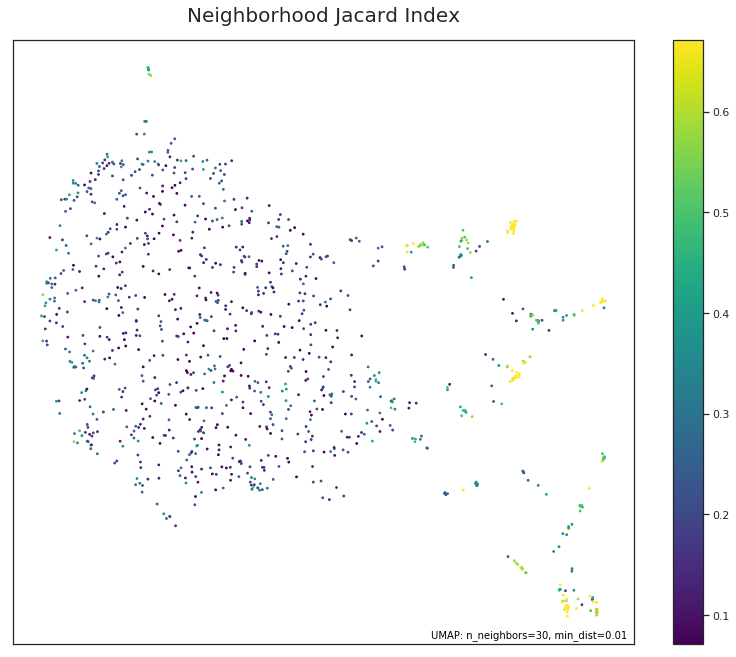

In [516]:
ax = umap.plot.diagnostic(mapper, diagnostic_type='pca')
ax.set_title('UMAP PCA Embedding', fontsize = 20, y=1.02)
plt.savefig('Graphs/Clustering/umap_pca.pdf', format='pdf', transparent=True)
ax = umap.plot.diagnostic(mapper, diagnostic_type='local_dim', width=910)
ax.set_title('Local Dimension', fontsize = 20, y=1.02)
plt.savefig('Graphs/Clustering/umap_local.pdf', format='pdf', transparent=True)
ax = umap.plot.diagnostic(mapper, diagnostic_type='neighborhood', width=910)
ax.set_title('Neighborhood Jacard Index', fontsize = 20, y=1.02)
plt.savefig('Graphs/Clustering/umap_neighbors.pdf', format='pdf', transparent=True)


In [517]:
#HDBSCAN
hdb = hdbscan.HDBSCAN(min_cluster_size=30, min_samples=5)

y_hdb = hdb.fit_predict(clusterable_embedding)
hdb = pd.Series(y_hdb)
hdb = hdb.replace(-1, "NA").replace(0, "AD 3").replace(1, "AD 2").replace(2, "AD 1").replace(3, "CONTROL")

colors_hdb = {"NA":"grey", "AD 3":"red", "AD 2":"green", "AD 1":"blue", "CONTROL":"purple"}

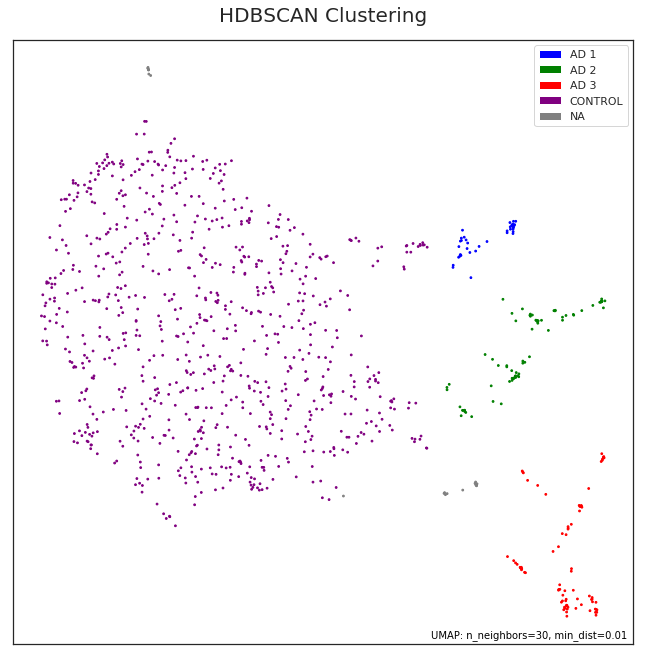

In [518]:
ax = umap.plot.points(mapper, labels=hdb, color_key=colors_hdb)
ax.set_title('HDBSCAN Clustering', fontsize = 20, y=1.02)
plt.savefig('Graphs/Clustering/hdbscan.pdf', format='pdf', transparent=True)

In [519]:
pd.crosstab(y, hdb, margins=True)

1,AD,CN,EMCI,LMCI,All
col_0,,,,,
AD 1,38,0,0,0,NaN
AD 2,70,2,2,1,NaN
AD 3,82,1,0,0,NaN
CONTROL,51,256,258,259,NaN
NA,19,1,0,0,NaN
All,0,0,0,0,1040.0


In [520]:
# Cluster Evaluation
clustered = (hdb != "NA")
print("Adjusted Rand Index:", round(adjusted_rand_score(y_ad[clustered], hdb[clustered]), 4))
print("Adjusted Mutual Information:", round(adjusted_mutual_info_score(y_ad[clustered], hdb[clustered]), 4))

Adjusted Rand Index: 0.7215
Adjusted Mutual Information: 0.5416


In [521]:
# Percent Clustered
print("Percent Clustered:", str(round(100*np.sum(clustered)/y_ad.shape[0], 2)) + "%")

Percent Clustered: 98.08%


## Random Forest Probabilities

In [522]:
#Load Data
probs = pd.read_csv('Output/Random Forest Probabilities.txt', index_col=0, header=0)
probs

,AD,CN,EMCI,LMCI
0,0.143,0.307,0.273,0.277
1,0.196,0.243,0.325,0.236
2,0.826,0.058,0.061,0.055
3,0.037,0.336,0.315,0.312
4,0.130,0.149,0.574,0.147
...,...,...,...,...
1035,0.162,0.190,0.218,0.430
1036,0.072,0.256,0.209,0.463
1037,0.120,0.168,0.182,0.530
1038,0.022,0.201,0.216,0.561


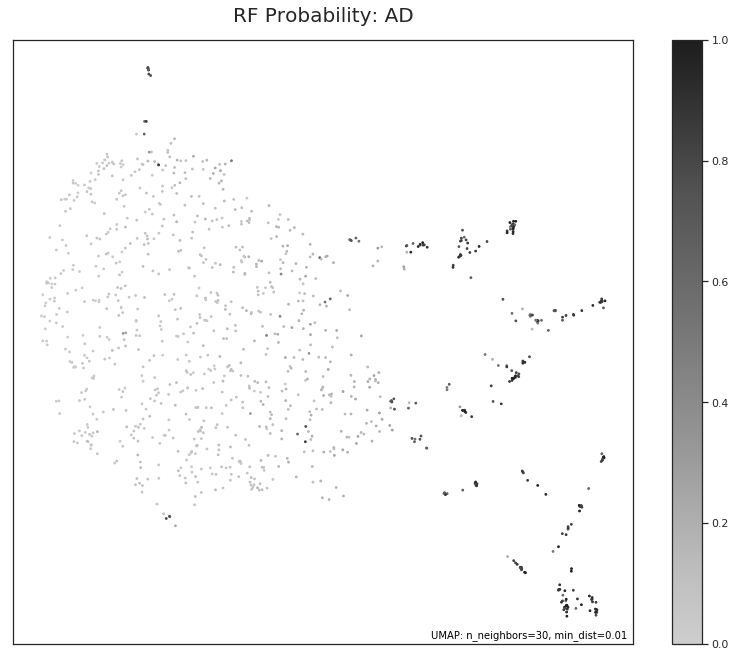

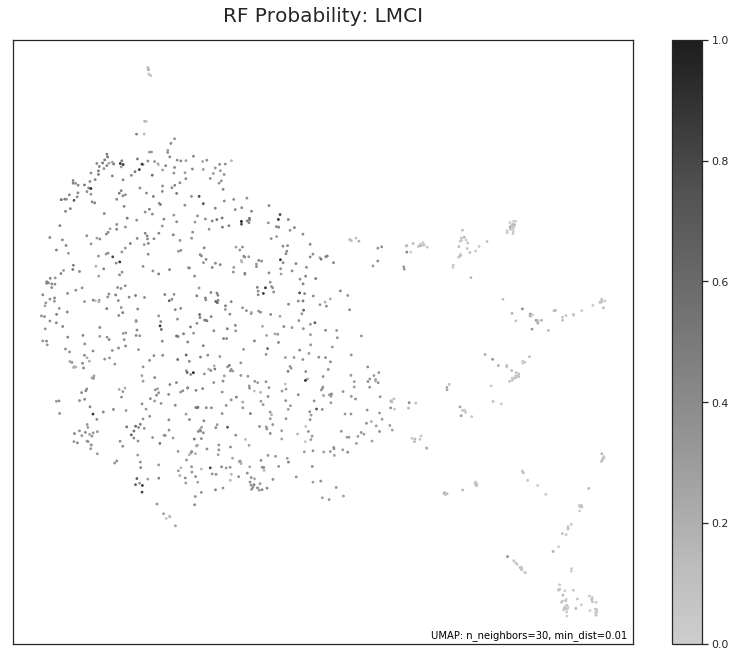

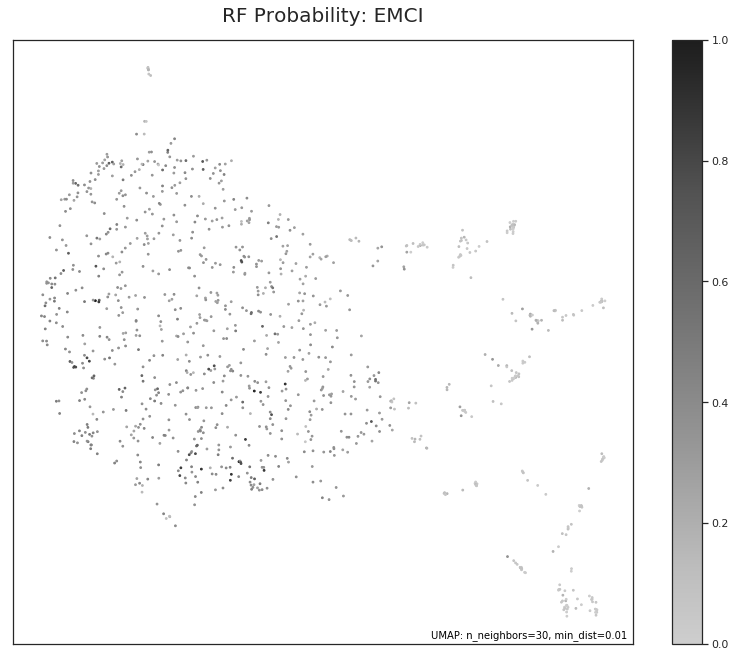

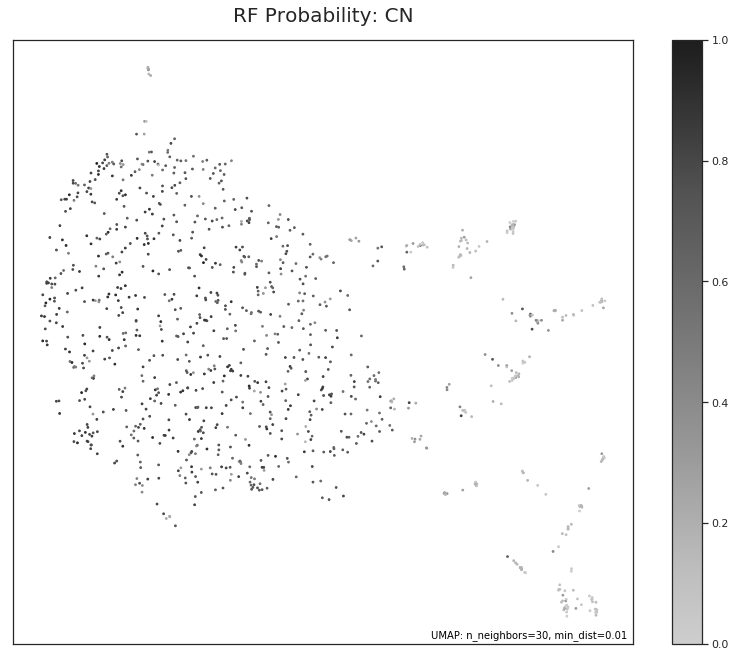

In [523]:
Greys = cm.get_cmap('Greys', 2048)
newcmp = ListedColormap(Greys(np.linspace(0.3, 0.9, 2048)))

ax = umap.plot.points(mapper, values=probs['AD'], cmap=newcmp, width=1000)
ax.set_title('RF Probability: AD', fontsize = 20, y=1.02)
plt.savefig('Graphs/Clustering/rf-ad.pdf', format='pdf', transparent=True)
ax = umap.plot.points(mapper, values=probs['LMCI'], cmap=newcmp, width=1000)
ax.set_title('RF Probability: LMCI', fontsize = 20, y=1.02)
plt.savefig('Graphs/Clustering/rf-lmci.pdf', format='pdf', transparent=True)
ax = umap.plot.points(mapper, values=probs['EMCI'], cmap=newcmp, width=1000)
ax.set_title('RF Probability: EMCI', fontsize = 20, y=1.02)
plt.savefig('Graphs/Clustering/rf-emci.pdf', format='pdf', transparent=True)
ax = umap.plot.points(mapper, values=probs['CN'], cmap=newcmp, width=1000)
ax.set_title('RF Probability: CN', fontsize = 20, y=1.02)
plt.savefig('Graphs/Clustering/rf-cn.pdf', format='pdf', transparent=True)

## Heatmap

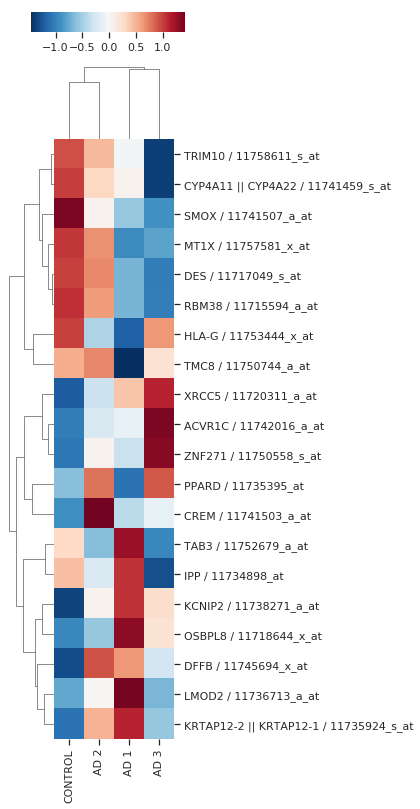

In [524]:
geheatmapclust(X, hdb, title='HDBSCAN Clustering of UMAP', side=2, top=0.5)
plt.savefig('Graphs/Clustering/heatmap.pdf', format='pdf', transparent=True)

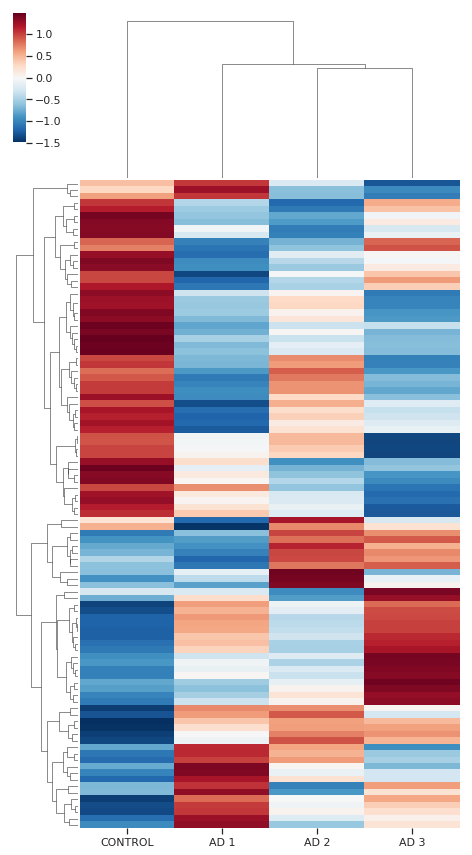

In [525]:
# Mean
ge = pd.DataFrame()
c = hdb[hdb!="NA"]
for i in c.unique():
    ge[i] = X.T[c[c==i].index].mean(axis=1)

# Clutermap
sns.clustermap(ge, figsize=(8, 15), cmap='RdBu_r', z_score=0, yticklabels=False)
plt.savefig('Graphs/Clustering/heatmapall.pdf', format='pdf', transparent=True)

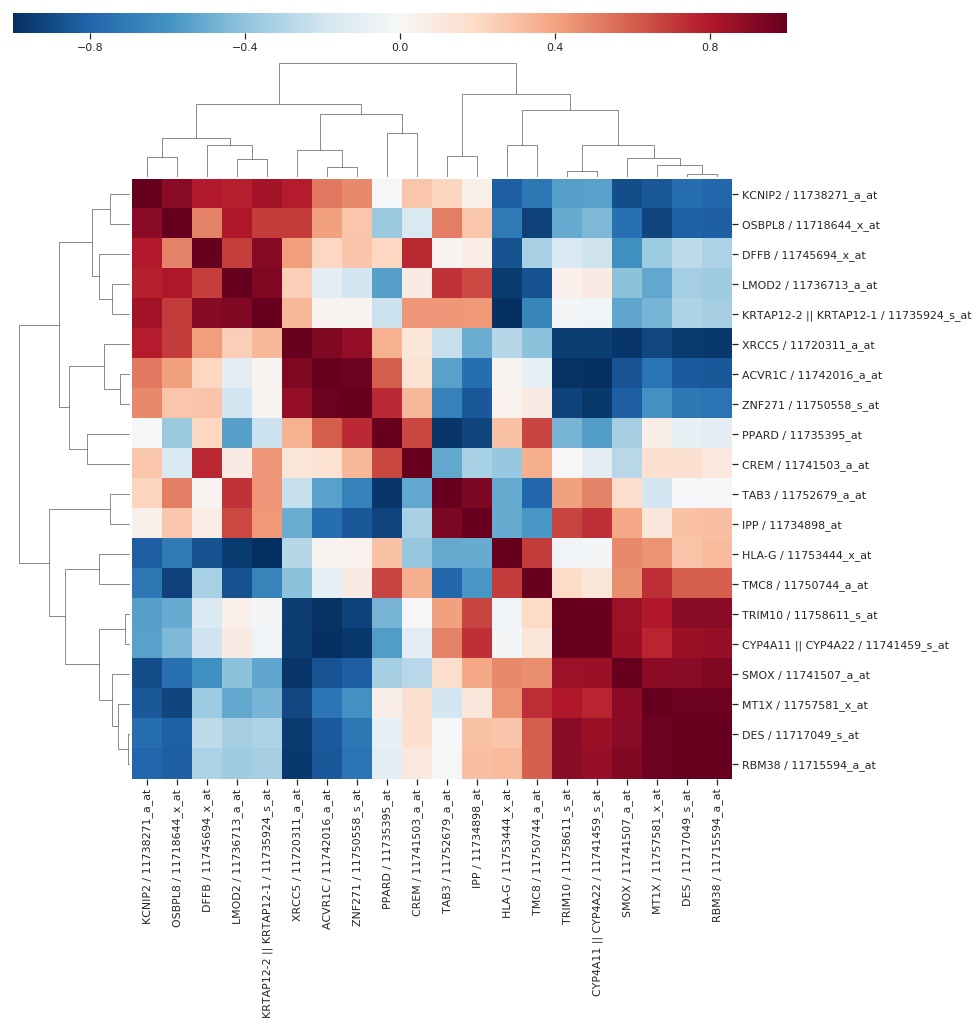

In [526]:
geheatmapclustgene(X, hdb, title='HDBSCAN Clustering of UMAP', top=1, side=1, up=0.25)
plt.savefig('Graphs/Clustering/heatmap_corr.pdf', format='pdf', transparent=True)

## Marker Genes

C:\Users\andre\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  """
C:\Users\andre\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  


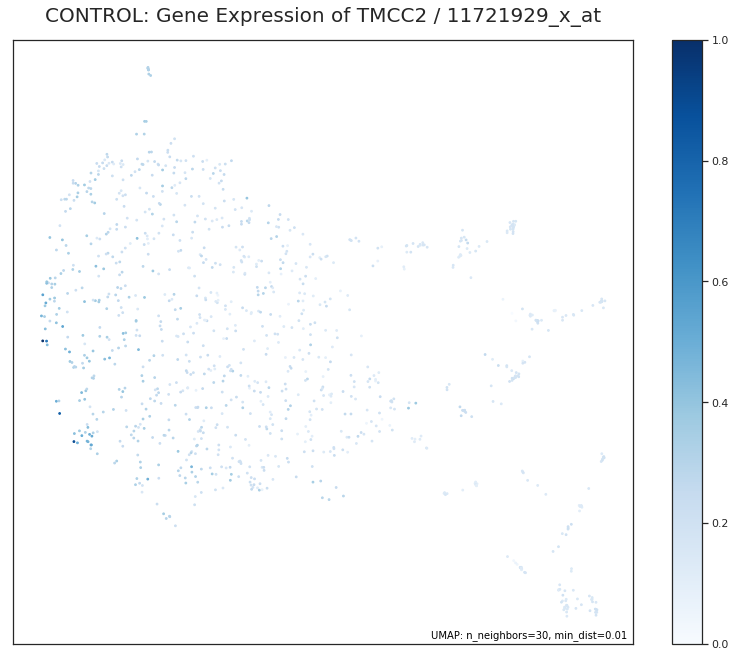

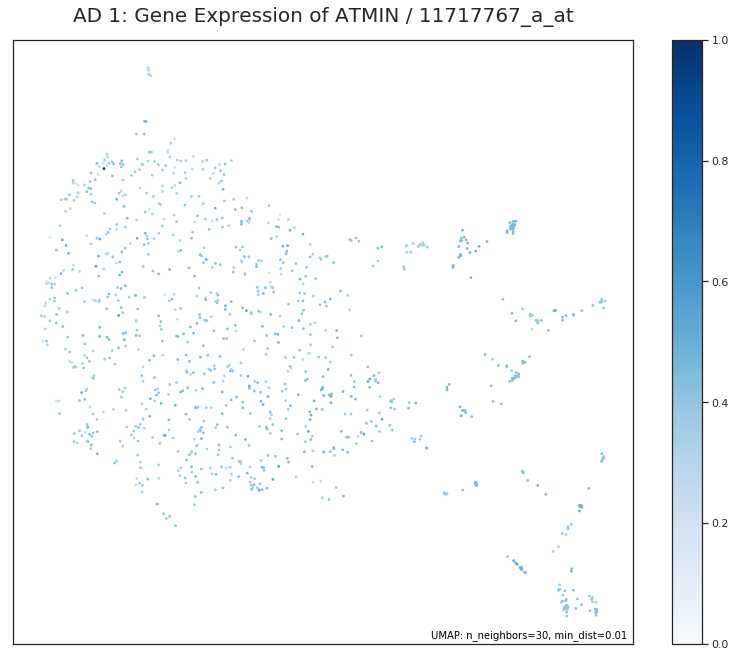

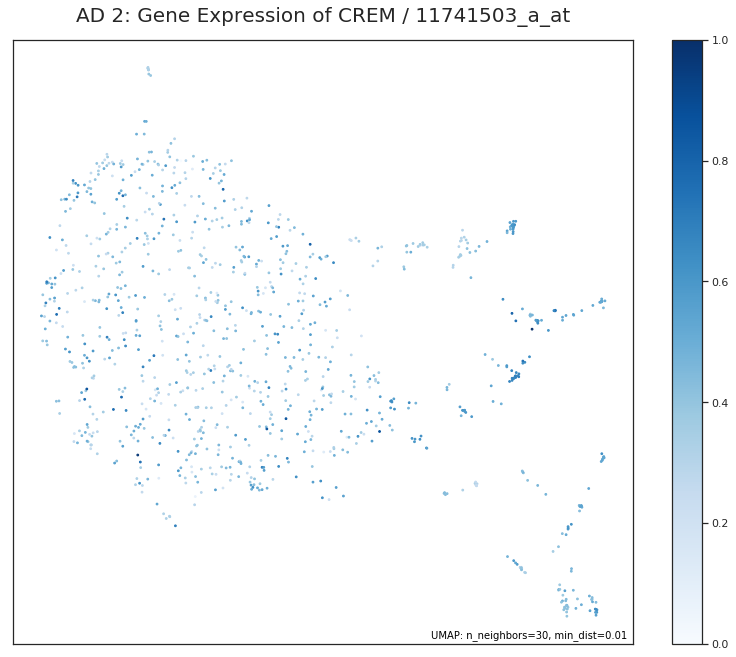

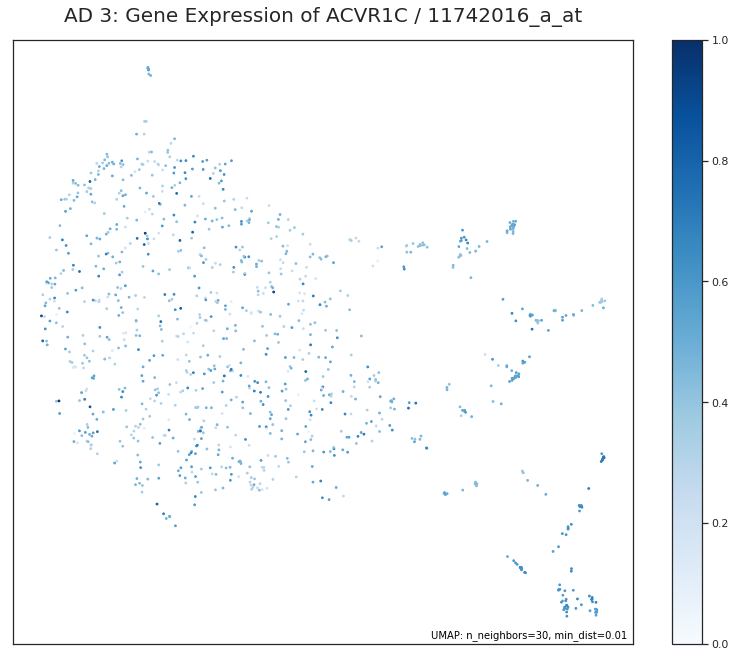

In [528]:
clust = hdb
for i in clust.unique():
    if i == "NA":
        continue
    pvalues = pd.Series(index=X.columns)
    statistics = pd.Series(index=X.columns)

    c = X.T[clust[clust == i].index]
    e = X.T[clust[clust != i].index]
    c_ = X.T[clust[clust == i].index].T
    e_ = X.T[clust[clust != i].index].T
    
    for gene in X.columns:
        statistics[gene], pvalues[gene] = stats.ranksums(c_[[gene]], e_[[gene]])
    
    markergene = statistics.sort_values(ascending=False).index[0]
    ax = umap.plot.points(mapper, values=X[markergene], cmap="Blues", width=1000)
    ax.set_title(i+': Gene Expression of '+markergene, fontsize = 20, y=1.02)
    plt.savefig('Graphs/Clustering/'+i+'.pdf', format='pdf', transparent=True)
    

## Wilcox

In [529]:
# Wilcox Score
pvalues = pd.Series(index=X.columns)
statistics = pd.Series(index=X.columns)

c = X.T[y[y == "AD"].index]
e = X.T[y[y != "AD"].index]
c_ = X.T[y[y == "AD"].index].T
e_ = X.T[y[y != "AD"].index].T

for gene in X.columns:
    statistics[gene], pvalues[gene] = stats.ranksums(c_[[gene]], e_[[gene]])

C:\Users\andre\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  
C:\Users\andre\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  This is separate from the ipykernel package so we can avoid doing imports until


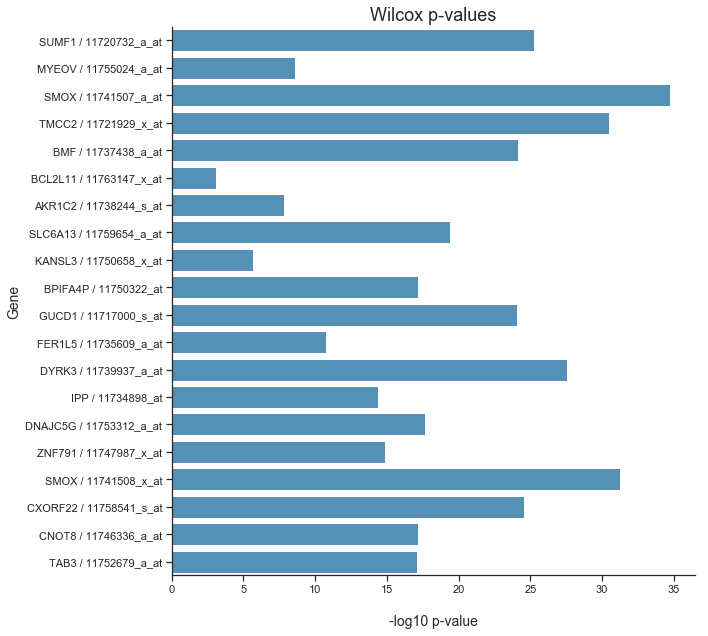

In [530]:
#Barplot
genes = X.columns[:20]

logp = pvalues.apply(np.log10)
logp = logp*-1

plt.figure(figsize = (10,9))
sns.set(font_scale=1)
sns.set_style("ticks")
sns.barplot(x=logp.loc[genes], y=genes, color = '#4594c7')
sns.despine()
plt.title('Wilcox p-values', fontsize=18)
plt.xlabel('-log10 p-value', fontsize=14,labelpad=20)
plt.ylabel('Gene', fontsize=14)
plt.tight_layout()
